In [65]:
# First, I imported the necessary libraries and dependencies
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import numpy as np
import alpaca_trade_api as tradeapi
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error



# Import the hvPlot library
import hvplot.pandas
import matplotlib.pyplot as plt

In [66]:
# Load .env environment variables
load_dotenv()

True

In [67]:
alpaca_api_key = os.getenv("api_keys_for_alpaca")
alpaca_secret_key = os.getenv("secret_api_key")

In [68]:
# I set the cryptocurrency (and other) parameters
cryptocurrency = 'ethereum'
start_date = '2018-09-01'
end_date = '2023-08-31'
vs_currency = 'usd'


In [69]:
# I Constructed the API URL
base_url = 'https://api.coingecko.com/api/v3'
url = f'{base_url}/coins/{cryptocurrency}/market_chart/range'
params = {
    'vs_currency': vs_currency,
    'from': pd.Timestamp(start_date).timestamp(),
    'to': pd.Timestamp(end_date).timestamp(),
}

In [70]:
# I made the API request
response = requests.get(url, params=params)
data = response.json()

In [71]:
# I Converted the data to a DataFrame
eth_df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'], unit='ms')
eth_df.set_index('timestamp', inplace=True)

In [72]:
eth_df.head()

,price
timestamp,
2018-09-01,282.223179
2018-09-02,295.646162
2018-09-03,294.585688
2018-09-04,288.852826
2018-09-05,285.485757


In [73]:
eth_df.tail()

,price
timestamp,
2023-08-27,1645.905000
2023-08-28,1656.931058
2023-08-29,1653.198566
2023-08-30,1730.190258
2023-08-31,1705.108103


In [74]:
eth_df_plot = eth_df.hvplot(
    title="Ethereum Price Action from 2018-Present",
    color="green",
    hover_color="purple"
)
eth_df_plot

:Curve   [timestamp]   (price)

In [75]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
eth_df['SMA_Fast'] = eth_df['price'].rolling(window=short_window).mean()
eth_df['SMA_Slow'] = eth_df['price'].rolling(window=long_window).mean()

eth_df = eth_df.dropna()

# Review the DataFrame
display(eth_df.head())
display(eth_df.tail())

,price,SMA_Fast,SMA_Slow
timestamp,,,
2018-12-09,90.678256,94.314602,195.488579
2018-12-10,93.530127,92.069373,193.601648
2018-12-11,89.853717,91.757513,191.543724
2018-12-12,87.850411,90.478128,189.476371
2018-12-13,89.377902,90.153039,187.481622


,price,SMA_Fast,SMA_Slow
timestamp,,,
2023-08-27,1645.905000,1659.214492,1832.549888
2023-08-28,1656.931058,1653.666258,1830.997881
2023-08-29,1653.198566,1652.365986,1829.340172
2023-08-30,1730.190258,1671.556221,1828.592784
2023-08-31,1705.108103,1686.356996,1827.459850


In [76]:
eth_df['Actual_Returns'] = eth_df['price'].pct_change() * 100  # Calculate as a percentage
eth_df.dropna(inplace=True)
eth_df

,price,SMA_Fast,SMA_Slow,Actual_Returns
timestamp,,,,
2018-12-10,93.530127,92.069373,193.601648,3.145044
2018-12-11,89.853717,91.757513,191.543724,-3.930722
2018-12-12,87.850411,90.478128,189.476371,-2.229520
2018-12-13,89.377902,90.153039,187.481622,1.738741
2018-12-14,85.958727,88.260189,185.486351,-3.825526
...,...,...,...,...
2023-08-27,1645.905000,1659.214492,1832.549888,-0.455074
2023-08-28,1656.931058,1653.666258,1830.997881,0.669909
2023-08-29,1653.198566,1652.365986,1829.340172,-0.225265


In [77]:
# Initialize the new Signal column
eth_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
eth_df.loc[(eth_df['Actual_Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
eth_df.loc[(eth_df['Actual_Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(eth_df.head())
display(eth_df.tail())

,price,SMA_Fast,SMA_Slow,Actual_Returns,Signal
timestamp,,,,,
2018-12-10,93.530127,92.069373,193.601648,3.145044,1.0
2018-12-11,89.853717,91.757513,191.543724,-3.930722,-1.0
2018-12-12,87.850411,90.478128,189.476371,-2.229520,-1.0
2018-12-13,89.377902,90.153039,187.481622,1.738741,1.0
2018-12-14,85.958727,88.260189,185.486351,-3.825526,-1.0


,price,SMA_Fast,SMA_Slow,Actual_Returns,Signal
timestamp,,,,,
2023-08-27,1645.905000,1659.214492,1832.549888,-0.455074,-1.0
2023-08-28,1656.931058,1653.666258,1830.997881,0.669909,1.0
2023-08-29,1653.198566,1652.365986,1829.340172,-0.225265,-1.0
2023-08-30,1730.190258,1671.556221,1828.592784,4.657135,1.0
2023-08-31,1705.108103,1686.356996,1827.459850,-1.449676,-1.0


In [78]:
# Identify the instances
eth_df['Signal'].value_counts()

 1.0    892
-1.0    834
Name: Signal, dtype: int64

In [79]:
# Calculate the strategy returns and add them to the signals_df DataFrame
eth_df['Strategy_Returns'] = eth_df['Actual_Returns'] * eth_df['Signal'].shift()

# Review the DataFrame
display(eth_df.head())
display(eth_df.tail())

,price,SMA_Fast,SMA_Slow,Actual_Returns,Signal,Strategy_Returns
timestamp,,,,,,
2018-12-10,93.530127,92.069373,193.601648,3.145044,1.0,NaN
2018-12-11,89.853717,91.757513,191.543724,-3.930722,-1.0,-3.930722
2018-12-12,87.850411,90.478128,189.476371,-2.229520,-1.0,2.229520
2018-12-13,89.377902,90.153039,187.481622,1.738741,1.0,-1.738741
2018-12-14,85.958727,88.260189,185.486351,-3.825526,-1.0,-3.825526


,price,SMA_Fast,SMA_Slow,Actual_Returns,Signal,Strategy_Returns
timestamp,,,,,,
2023-08-27,1645.905000,1659.214492,1832.549888,-0.455074,-1.0,0.455074
2023-08-28,1656.931058,1653.666258,1830.997881,0.669909,1.0,-0.669909
2023-08-29,1653.198566,1652.365986,1829.340172,-0.225265,-1.0,-0.225265
2023-08-30,1730.190258,1671.556221,1828.592784,4.657135,1.0,-4.657135
2023-08-31,1705.108103,1686.356996,1827.459850,-1.449676,-1.0,-1.449676


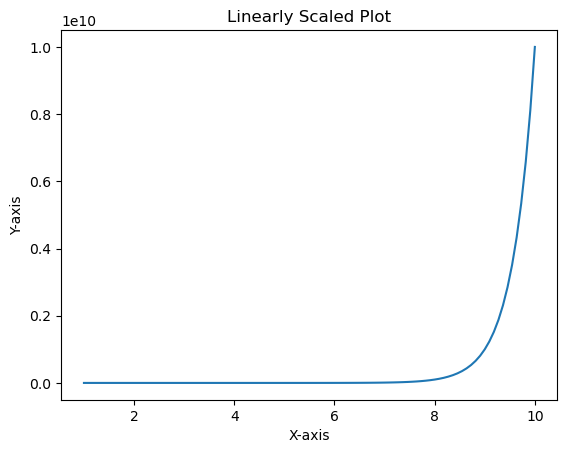

In [104]:
# Plot Strategy Returns to examine performance
x = np.linspace(1, 10, 100)
y = 10 ** x  # Exponential growth

plt.plot(x, y)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Linearly Scaled Plot')
plt.show()

In [105]:
# Split the data into training and testing datasets
# Assign a copy of the sma_fast and sma_slow columns to features DataDrame called x
X = eth_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()


,SMA_Fast,SMA_Slow
timestamp,,
2018-12-11,92.069373,193.601648
2018-12-12,91.757513,191.543724
2018-12-13,90.478128,189.476371
2018-12-14,90.153039,187.481622
2018-12-15,88.260189,185.486351


In [106]:
# Create the target set selecting the Signal column and assigning it a y
y = eth_df['Signal']

# Review the value counts
y.value_counts()

 1.0    892
-1.0    834
Name: Signal, dtype: int64

In [107]:
# Select the start of the training period
training_begin = X.index.min() 

# Display the training begin date
print(training_begin)

2018-12-11 00:00:00


In [108]:
# Select the ending period for training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-03-11 00:00:00


In [109]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()

,SMA_Fast,SMA_Slow
timestamp,,
2019-03-07,131.280526,120.373330
2019-03-08,132.510332,120.652286
2019-03-09,134.071781,120.915798
2019-03-10,136.051184,121.026751
2019-03-11,136.212622,121.221657


In [110]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.tail()

,SMA_Fast,SMA_Slow
timestamp,,
2023-08-27,1656.536065,1834.114747
2023-08-28,1659.214492,1832.549888
2023-08-29,1653.666258,1830.997881
2023-08-30,1652.365986,1829.340172
2023-08-31,1671.556221,1828.592784


In [111]:
# Scale the features DataFrames
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [112]:
# Using the SVC Classifier Model from SKLeans Support Vector Machine (SVM) Learning Method to fit the training data and make predictions based on the testing data. 
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred_training = svm_model.predict(X_train_scaled)
svm_pred_testing = svm_model.predict(X_test_scaled)

# Review the model's predicted values
# YOUR CODE HERE
svm_pred_testing[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [113]:
# Review the classification Report associated with the SVC Models
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred_testing)

# Print the classification report
# YOUR CODE HERE
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.48      0.98      0.65       786
         1.0       0.55      0.02      0.04       848

    accuracy                           0.48      1634
   macro avg       0.51      0.50      0.34      1634
weighted avg       0.52      0.48      0.33      1634



In [114]:
# Create a predictions DataFrame that contains columns for "Predicted" and "Actual Returns" and Strategy Returns"
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred_testing

# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = eth_df['Actual_Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy_Returns'] = predictions_df['Actual_Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2019-03-12,-1.0,-2.384050,2.384050
2019-03-13,-1.0,0.679740,-0.679740
2019-03-14,-1.0,-1.214729,1.214729
2019-03-15,-1.0,0.362952,-0.362952
2019-03-16,-1.0,3.255202,-3.255202


,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2023-08-27,-1.0,-0.455074,0.455074
2023-08-28,-1.0,0.669909,-0.669909
2023-08-29,-1.0,-0.225265,0.225265
2023-08-30,-1.0,4.657135,-4.657135
2023-08-31,-1.0,-1.449676,1.449676


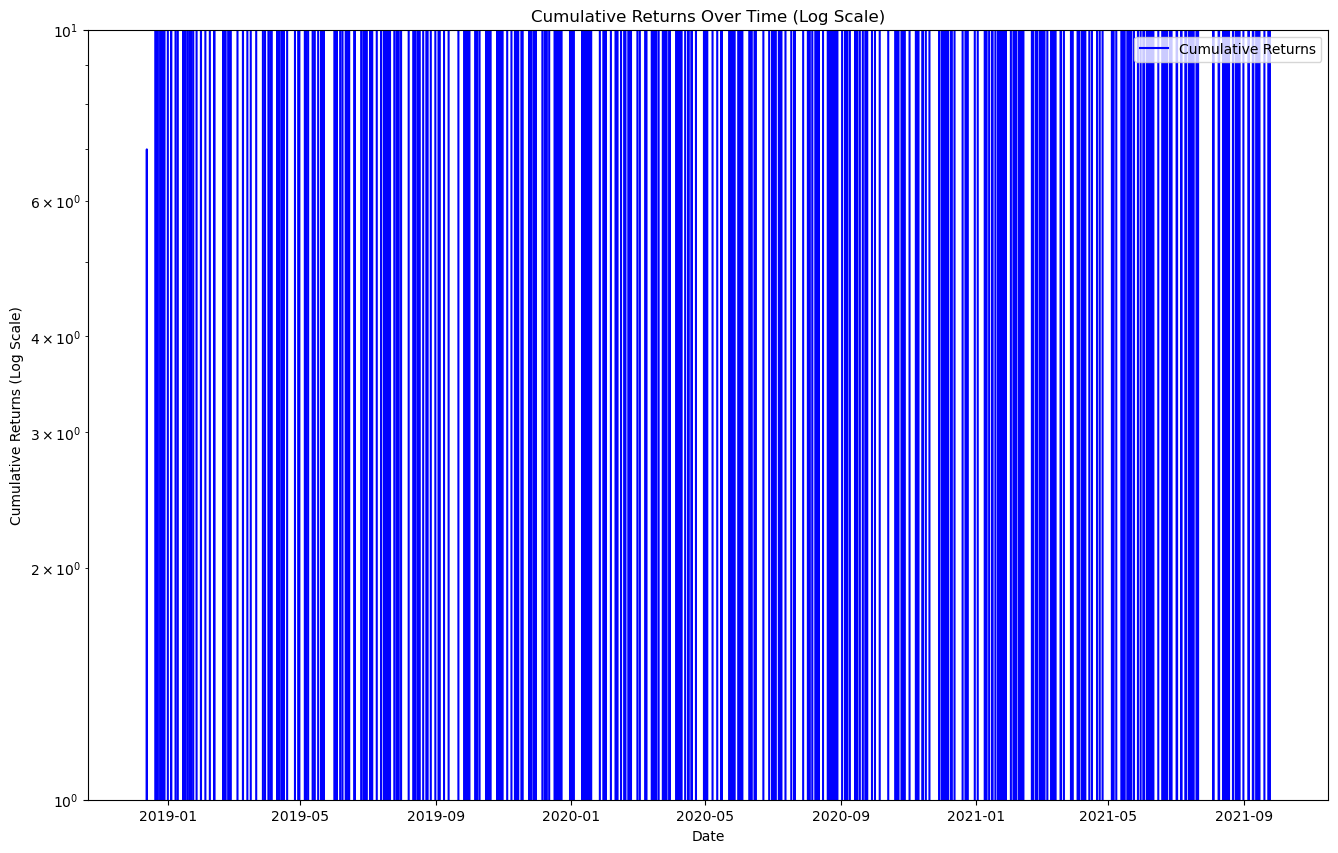

In [120]:
# Assuming eth_df is your DataFrame containing returns data

# Calculate cumulative returns
eth_df['Cumulative_Returns'] = (1 + eth_df['Strategy_Returns']).cumprod()

# Plot cumulative returns with a logarithmic y-axis scale
plt.figure(figsize=(16, 10))
plt.semilogy(eth_df.index, eth_df['Cumulative_Returns'], label='Cumulative Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (Log Scale)')
plt.title('Cumulative Returns Over Time (Log Scale)')
plt.legend()

# Save the figure to a file (e.g., PNG)
plt.savefig('cumulative_returns_plot.png')

# Show the plot (optional)
plt.show()


In [121]:
# Tune the Baseline and Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression 

# Initiate the model instance
logistic_regression_model = LogisticRegression()

In [122]:
# Using the original training data as the baseline, fit the model with Logistics Regression
logistic_regression_model = logistic_regression_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
lr_pred_train = logistic_regression_model.predict(X_train_scaled)

# Review the model's predicted values
lr_pred_train 

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [123]:
# Generate a classification report using the training data and the logistics regression model's predictions
lr_training_report = classification_report(y_train, lr_pred_train)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.56      0.83      0.67        48
         1.0       0.58      0.26      0.35        43

    accuracy                           0.56        91
   macro avg       0.57      0.54      0.51        91
weighted avg       0.57      0.56      0.52        91



In [124]:
# Backtest the new model to evaluate performance 
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_predict = logistic_regression_model.predict(X_test_scaled)

# Generate the classification report 
lr_testing_report = classification_report(y_test, lr_testing_predict)

# Print the classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.48      1.00      0.65       786
         1.0       0.00      0.00      0.00       848

    accuracy                           0.48      1634
   macro avg       0.24      0.50      0.32      1634
weighted avg       0.23      0.48      0.31      1634



C:\Users\mfasi\.conda\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mfasi\.conda\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mfasi\.conda\envs\alpacaenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
# Create a new empty predictions DataFrame:
lr_predict_df = pd.DataFrame(index=X_test.index)

# Add the Logistic Regression model predictions to the DataFrame
lr_predict_df['Predicted'] = lr_testing_predict

# Add the actual returns to the DataFrame
lr_predict_df['Actual_Returns'] = eth_df['Actual_Returns']

# Add the strategy returns to the DataFrame
lr_predict_df['Strategy_Returns'] = lr_predict_df['Actual_Returns'] * lr_predict_df['Predicted']

# Review the DataFrame
display(lr_predict_df.head())
display(lr_predict_df.tail())

,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2019-03-12,-1.0,-2.384050,2.384050
2019-03-13,-1.0,0.679740,-0.679740
2019-03-14,-1.0,-1.214729,1.214729
2019-03-15,-1.0,0.362952,-0.362952
2019-03-16,-1.0,3.255202,-3.255202


,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2023-08-27,-1.0,-0.455074,0.455074
2023-08-28,-1.0,0.669909,-0.669909
2023-08-29,-1.0,-0.225265,0.225265
2023-08-30,-1.0,4.657135,-4.657135
2023-08-31,-1.0,-1.449676,1.449676


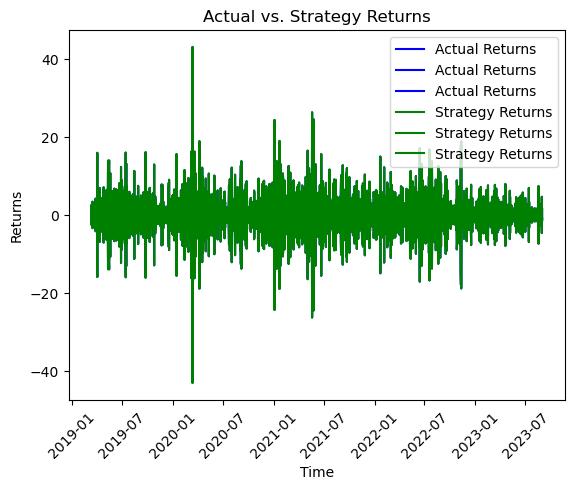

In [126]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot actual returns in blue and label it
ax.plot(lr_predict_df, label='Actual Returns', color='blue')

# Plot strategy returns in green and label it
ax.plot(lr_predict_df, label='Strategy Returns', color='green')

# Add labels and a legend
ax.set_xlabel('Time')
ax.set_ylabel('Returns')
ax.set_title('Actual vs. Strategy Returns')
ax.legend()
ax.tick_params(axis='x', rotation=45)
# Save the figure to a file (e.g., PNG)
plt.savefig("Actual_vs_Strategy_Returns.png")

# Show the plot (optional)
plt.show()


In [127]:
# ... (your existing code)

# Create a new empty predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred_testing

# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = eth_df['Actual_Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy_Returns'] = predictions_df['Actual_Returns'] * predictions_df['Predicted']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(predictions_df['Actual_Returns'], predictions_df['Strategy_Returns'])

# Print the MAE
print(f"Mean Absolute Error (MAE): {mae}")

# ... (the rest of your code)

Mean Absolute Error (MAE): 6.1661543884982715
